In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from classes.edge_detector import EdgeDetector
from classes.frequency_processor import FrequencyProcessor
from classes.histogram_processor import HistogramProcessor
from itertools import combinations
from collections import defaultdict
from utils import *
import cv2
import os


In [2]:
lena_path = '../data/lena.png'
cameraman_path = '../data/cameraman.png'
random_shape_path = '../data/tes_contour.jpeg'
ellipse_path = '../data/ellipses.png'

In [3]:
lena_image = cv2.imread(lena_path, cv2.COLOR_BGR2RGB)
cameraman_image = cv2.imread(cameraman_path,  cv2.COLOR_BGR2RGB)
lena_image_gray = cv2.cvtColor(lena_image, cv2.COLOR_BGR2GRAY)

random_shape_image = cv2.imread(random_shape_path, cv2.COLOR_BGR2RGB)
cameraman_image_gray = cv2.cvtColor(cameraman_image, cv2.COLOR_BGR2GRAY)
random_shape_image_gray = cv2.cvtColor(random_shape_image, cv2.COLOR_BGR2GRAY)

ellipse_image = cv2.imread(ellipse_path, cv2.COLOR_BGR2RGB)
ellipse_image_gray = cv2.cvtColor(ellipse_image, cv2.COLOR_BGR2GRAY)


Testing Frequency filters

In [ ]:
processor = FrequencyProcessor()


In [ ]:

# Set the image and compute its DFT
processor.set_image(lena_image_gray)

# Apply a low-pass filter
low_pass_filter = processor.apply_filter(radius=30, filter_type="low_pass")

# Apply a high-pass filter
high_pass_filtered_image = processor.apply_filter(radius=40, filter_type="hp")

# Display the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(lena_image_gray, cmap='gray')


plt.subplot(1, 3, 1)
plt.title('Low-Pass Filtered Image')
plt.imshow(low_pass_filter, cmap='gray')

# High-Pass Filtered Image
plt.subplot(1, 3, 3)
plt.title('High-Pass Filtered Image')
plt.imshow(high_pass_filtered_image, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
processor.filter_type

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def ideal_filter(dft_shifted, cutoff=10, type="low_pass"):
    """
    Creates an ideal low-pass or high-pass filter mask.
    
    :param dft_shifted: Shifted DFT of the image.
    :param cutoff: Cutoff frequency (radius).
    :param type: Type of filter ('low_pass' or 'high_pass').
    :return: Filter mask.
    """
    rows, cols = dft_shifted.shape
    center = (rows // 2, cols // 2)
    
    # Create a grid of distances from the center
    x = np.arange(cols) - center[1]
    y = np.arange(rows) - center[0]
    xx, yy = np.meshgrid(x, y)
    distance = np.sqrt(xx**2 + yy**2)
    
    # Create the mask based on the filter type
    if type == "low_pass" or type == "lp":  # Low-pass filter
        mask = (distance <= cutoff).astype(np.uint8)
    elif type == "high_pass" or type == "hp":  # High-pass filter
        mask = (distance > cutoff).astype(np.uint8)
    else:
        raise ValueError("Invalid filter type. Use 'lp' or 'hp'.")
    
    return mask

def calculate_dft(img):
    """
    Computes the DFT of an image and returns the shifted DFT and its magnitude spectrum.
    
    :param img: Input image.
    :return: Tuple (shifted DFT, magnitude spectrum).
    """
    dft = np.fft.fft2(img)
    dft_shifted = np.fft.fftshift(dft)
    magnitude_spectrum = np.log(1 + np.abs(dft_shifted))  # Log scale for visualization
    return dft_shifted, magnitude_spectrum

def filter_image(dft_shifted, mask):
    """
    Applies a filter mask to the DFT and reconstructs the image.
    
    :param dft_shifted: Shifted DFT of the image.
    :param mask: Filter mask.
    :return: Filtered image in the spatial domain.
    """
    filtered_dft = dft_shifted * mask
    inverse_dft = np.fft.ifftshift(filtered_dft)
    image_filtered = np.fft.ifft2(inverse_dft)
    image_filtered = np.abs(image_filtered)
    image_filtered = np.clip(image_filtered, 0, 255).astype(np.uint8)
    return image_filtered

def visualize_steps(image, dft_shifted, magnitude_spectrum, mask, filtered_image, filter_type):
    """
    Visualizes each step of the filtering process.
    
    :param image: Original image.
    :param dft_shifted: Shifted DFT of the image.
    :param magnitude_spectrum: Magnitude spectrum of the DFT.
    :param mask: Filter mask.
    :param filtered_image: Filtered image in the spatial domain.
    :param filter_type: Type of filter ('low_pass' or 'high_pass').
    """
    plt.figure(figsize=(15, 10))
    
    # Original Image
    plt.subplot(2, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    
    # Magnitude Spectrum
    plt.subplot(2, 3, 2)
    plt.title('Magnitude Spectrum')
    plt.imshow(magnitude_spectrum, cmap='gray')
    
    # Filter Mask
    plt.subplot(2, 3, 3)
    plt.title(f'{filter_type.capitalize()} Filter Mask')
    plt.imshow(mask, cmap='gray')
    
    # Filtered DFT (Magnitude Spectrum)
    filtered_magnitude = np.log(1 + np.abs(dft_shifted * mask)) # Log scale for visualization
    plt.subplot(2, 3, 4)
    plt.title('Filtered Magnitude Spectrum')
    plt.imshow(filtered_magnitude, cmap='gray')
    
    # Reconstructed Image
    plt.subplot(2, 3, 5)
    plt.title(f'{filter_type.capitalize()} Filtered Image')
    plt.imshow(filtered_image, cmap='gray')
    
    plt.tight_layout()
    plt.show()

# Compute the DFT and magnitude spectrum
dft_shifted, magnitude_spectrum = calculate_dft(lena_image_gray)

# Apply low-pass filter
cutoff_low = 30  # Cutoff frequency for low-pass filter
low_pass_mask = ideal_filter(dft_shifted, cutoff=cutoff_low, type="low_pass")
low_pass_filtered_image = filter_image(dft_shifted, low_pass_mask)

# Visualize low-pass filter steps
visualize_steps(lena_image_gray, dft_shifted, magnitude_spectrum, low_pass_mask, low_pass_filtered_image, filter_type="low_pass")

# Apply high-pass filter
cutoff_high = 30  # Cutoff frequency for high-pass filter
high_pass_mask = ideal_filter(dft_shifted, cutoff=cutoff_high, type="high_pass")
high_pass_filtered_image = filter_image(dft_shifted, high_pass_mask)

# Visualize high-pass filter steps
visualize_steps(lena_image_gray, dft_shifted, magnitude_spectrum, high_pass_mask, high_pass_filtered_image, filter_type="high_pass")

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

processor = HistogramProcessor()
# Check if the image was loaded successfully
if image is None:
    raise ValueError("Image not found. Please check the file path.")


# Set the image
processor.set_image(lena_image)
print(processor.is_color)
# Test histogram equalization
equalized_image = processor.apply_histogram_equalization()

# Display the original and equalized images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
if processor.is_color:
    plt.imshow(cv2.cvtColor(processor.image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
else:
    plt.imshow(processor.image, cmap='gray')

# Equalized Image
plt.subplot(1, 2, 2)
plt.title('Equalized Image')
if processor.is_color:
    plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
else:
    plt.imshow(equalized_image, cmap='gray')

plt.tight_layout()
plt.show()

# Test histogram and CDF plotting
if processor.is_color:
    for channel in ["Red", "Green", "Blue"]:
        processor.plot_histogram_with_distribution(channel)
else:
    processor.plot_histogram_with_distribution()

# Test histogram with normal distribution curve
if processor.is_color:
    for channel in ["Red", "Green", "Blue"]:
        processor.plot_histogram_with_normal_distribution(channel)
else:
    processor.plot_histogram_with_normal_distribution()

# Test plotting all histograms with normal distribution curves
processor.plot_all_histograms_with_normal_distribution()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sobel_edge_detection(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return

    # Compute Sobel derivatives in x and y directions
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal derivative
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Vertical derivative

    # Compute the gradient magnitude
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize the gradient magnitude to the range [0, 255]
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Display the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Sobel X (Horizontal Edges)")
    plt.imshow(np.abs(sobel_x), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Sobel Y (Vertical Edges)")
    plt.imshow(np.abs(sobel_y), cmap='gray')

    plt.figure(figsize=(10, 5))
    plt.title("Gradient Magnitude (Edges)")
    plt.imshow(gradient_magnitude, cmap='gray')

    plt.show()

# Example usage


In [ ]:
sobel_edge_detection(img_path)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import numpy as np

def localthresholding_numpy(image, kernel_size=3, k=1):
    """
    Local thresholding using Niblack's method (implemented with NumPy only).
    
    :param image: Input grayscale image (NumPy array).
    :param kernel_size: Size of the local neighborhood (must be odd).
    :param k: Sensitivity parameter for Niblack's method.
    :return: Binary image after thresholding.
    """
    # Ensure kernel_size is odd
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Pad the image to handle borders
    pad = kernel_size // 2
    padded_image = np.pad(image, pad, mode='constant')

    # Create a uniform kernel
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float64) / (kernel_size ** 2)

    # Compute local mean using convolution
    local_mean = convolve2d(padded_image, kernel, mode='valid')

    # Compute local squared mean using convolution
    squared_image = padded_image ** 2
    local_sq_mean = convolve2d(squared_image, kernel, mode='valid')

    # Compute local standard deviation
    variance = local_sq_mean - local_mean**2
    variance = np.maximum(variance, 0)  # Clip negative values to zero
    local_std = np.sqrt(variance)
 
    # Calculate the threshold using Niblack's method
    threshold = local_mean + k * local_std

    # Apply the threshold
    binary_image = np.where(image > threshold, 255, 0).astype(np.uint8)

    return binary_image

def convolve2d(image, kernel, mode='valid'):
    """
    Performs 2D convolution using NumPy.
    
    :param image: Input image (2D NumPy array).
    :param kernel: Convolution kernel (2D NumPy array).
    :param mode: Convolution mode ('valid', 'same', or 'full').
    :return: Convolved image.
    """
    # Flip the kernel for convolution
    kernel = np.flipud(np.fliplr(kernel))

    # Get dimensions
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Determine output shape based on mode
    if mode == 'valid':
        output_height = image_height - kernel_height + 1
        output_width = image_width - kernel_width + 1
    elif mode == 'same':
        output_height = image_height
        output_width = image_width
    elif mode == 'full':
        output_height = image_height + kernel_height - 1
        output_width = image_width + kernel_width - 1
    else:
        raise ValueError("Invalid mode. Use 'valid', 'same', or 'full'.")

    # Initialize output
    output = np.zeros((output_height, output_width))

    # Perform convolution
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = np.sum(image[i:i+kernel_height, j:j+kernel_width] * kernel)

    return output
# Apply local thresholding
binary_image = localthresholding_numpy(lena_image_gray,3, k=1)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(lena_image_gray, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Local Thresholding (Niblack)")
plt.imshow(binary_image, cmap='gray')

plt.show()

In [ ]:
import numpy as np

def integral_image(image):
    """
    Compute the integral image of a given image.
    
    :param image: Input grayscale image (2D NumPy array).
    :return: Integral image.
    """
    return np.cumsum(np.cumsum(image, axis=0), axis=1)

def _mean_std(image, w):
    """
    Return local mean and standard deviation of each pixel using a
    neighborhood defined by a rectangular window with size w x w.
    The algorithm uses integral images to speed up computation.

    :param image: Input grayscale image (2D NumPy array).
    :param w: Odd window size (e.g., 3, 5, 7, ..., 21, ...).
    :return: Tuple (m, s) where:
             - m: 2D array of local mean values.
             - s: 2D array of local standard deviation values.
    """
    if w == 1 or w % 2 == 0:
        raise ValueError(f"Window size w = {w} must be odd and greater than 1.")

    # Pad the image to handle borders
    pad = w // 2
    padded = np.pad(image.astype('float'), ((pad, pad), (pad, pad)), mode='reflect')
    padded_sq = padded * padded

    # Compute integral images
    integral = integral_image(padded)
    integral_sq = integral_image(padded_sq)

    # Define the kernel for computing sums
    kern = np.zeros((w + 1, w + 1))
    kern[0, 0] = 1
    kern[0, -1] = -1
    kern[-1, 0] = -1
    kern[-1, -1] = 1

    # Compute local sums using the kernel
    sum_full = np.zeros_like(image, dtype=np.float64)
    sum_sq_full = np.zeros_like(image, dtype=np.float64)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Coordinates in the padded image
            i_pad = i + pad
            j_pad = j + pad

            # Compute the sum using the integral image
            sum_full[i, j] = (
                integral[i_pad + 1, j_pad + 1] -
                integral[i_pad + 1, j_pad - w] -
                integral[i_pad - w, j_pad + 1] +
                integral[i_pad - w, j_pad - w]
            )
            sum_sq_full[i, j] = (
                integral_sq[i_pad + 1, j_pad + 1] -
                integral_sq[i_pad + 1, j_pad - w] -
                integral_sq[i_pad - w, j_pad + 1] +
                integral_sq[i_pad - w, j_pad - w]
            )

    # Compute local mean and standard deviation
    m = sum_full / (w ** 2)
    g2 = sum_sq_full / (w ** 2)
    s = np.sqrt(np.maximum(g2 - m * m, 0))  # Ensure non-negative values

    return m, s

def threshold_niblack(image, window_size=15, k=0.2):
    """
    Applies Niblack local thresholding to an image.

    :param image: Input grayscale image (2D NumPy array).
    :param window_size: Odd size of pixel neighborhood window (e.g., 3, 5, 7...).
    :param k: Value of parameter k in the threshold formula.
    :return: Binary image after thresholding.
    """
    # Compute local mean and standard deviation
    m, s = _mean_std(image, window_size)

    # Calculate the threshold using Niblack's method
    threshold = m - k * s

    # Apply the threshold
    binary_image = np.where(image > threshold, 255, 0).astype(np.uint8)

    return binary_image


# Apply local thresholding
binary_image = threshold_niblack(lena_image_gray,5, k=1)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(lena_image_gray, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Local Thresholding (Niblack)")
plt.imshow(binary_image, cmap='gray')

plt.show()

In [ ]:
import cv2
import numpy as np

def localthresholding_opencv(image, kernel_size=3, k=1):
    """
    Local thresholding using Niblack's method (optimized with OpenCV).
    
    :param image: Input grayscale image (NumPy array).
    :param kernel_size: Size of the local neighborhood (must be odd).
    :param k: Sensitivity parameter for Niblack's method.
    :return: Binary image after thresholding.
    """
    # Ensure kernel_size is odd
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Compute local mean using a box filter
    local_mean = cv2.boxFilter(image, -1, (kernel_size, kernel_size), normalize=True, borderType=cv2.BORDER_CONSTANT)

    # Compute local squared mean
    local_sq_mean = cv2.sqrBoxFilter(image, -1, (kernel_size, kernel_size), normalize=True, borderType=cv2.BORDER_CONSTANT)

    # Compute local standard deviation
    local_std = np.sqrt(local_sq_mean - local_mean**2)

    # Calculate the threshold using Niblack's method
    threshold = local_mean + k * local_std

    # Apply the threshold
    binary_image = np.where(image > threshold, 255, 0).astype(np.uint8)

    return binary_image

binary_image = localthresholding_opencv(lena_image_gray, kernel_size=10, k=0.5)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(lena_image_gray, cmap='gray')

plt.subplot(1, 2, 2)        
plt.title("Local Thresholding (Niblack, OpenCV)")
plt.imshow(binary_image, cmap='gray')

plt.show()

In [ ]:
def globalthresholding(image, T = 128, value = 255):
    binary_img  = (image > T).astype(np.uint8) * value
    return binary_img

binary_image = globalthresholding(lena_image_gray, T=100, value=255)


# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(lena_image_gray, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("global Thresholding (Niblack, OpenCV)")
plt.imshow(binary_image, cmap='gray')

plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt


# Initialize the EdgeDetector
edge_detector = EdgeDetector()

# Set the image
edge_detector.set_image(cameraman_image)

# Apply Sobel edge detection
sobel_edges = edge_detector.detect_edges(detector_method='sobel', kernel_size=3, sigma=1.0)

# Apply Canny edge detection
canny_edges = edge_detector.detect_edges(detector_method='canny', low_threshold=10, high_threshold=30)

# Apply Prewitt edge detection
prewitt_edges = edge_detector.detect_edges(detector_method='prewitt', threshold=50, value=255)

# Apply Roberts edge detection
roberts_edges = edge_detector.detect_edges(detector_method='roberts')

# Display the results
plt.figure(figsize=(12, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(cameraman_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display

# Sobel Edges
plt.subplot(2, 3, 2)
plt.title('Sobel Edges')
plt.imshow(sobel_edges, cmap='gray')

# Canny Edges
plt.subplot(2, 3, 3)
plt.title('Canny Edges')
plt.imshow(canny_edges, cmap='gray')

# Prewitt Edges
plt.subplot(2, 3, 4)
plt.title('Prewitt Edges')
plt.imshow(prewitt_edges, cmap='gray')

# Roberts Edges
plt.subplot(2, 3, 5)
plt.title('Roberts Edges')
plt.imshow(roberts_edges, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sobel_edge_detection(image, kernel_size=3, threshold=None):
    """
    Detect edges using the Sobel operator with OpenCV.
    
    :param image: Input grayscale image (2D NumPy array).
    :param kernel_size: Size of the Sobel kernel (must be 1, 3, 5, or 7).
    :param threshold: Threshold value for binarization (optional).
    :return: Edge map (binary if threshold is provided, otherwise gradient magnitude).
    """
    # Compute horizontal and vertical gradients using Sobel
    Gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    Gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)

    # Compute gradient magnitude
    G = np.sqrt(Gx**2 + Gy**2)

    # Normalize gradient magnitude to [0, 255]
    G_normalized = np.uint8(255 * (G / np.max(G)))

    # Apply thresholding if a threshold is provided
    if threshold is not None:
        _, binary_edge_map = cv2.threshold(G_normalized, threshold, 255, cv2.THRESH_BINARY)
        return binary_edge_map
    else:
        return G_normalized

# Apply Sobel edge detection without thresholding
edges_normalized = sobel_edge_detection(lena_image_gray, kernel_size=3)

# Apply Sobel edge detection with thresholding
edges_binary = sobel_edge_detection(lena_image_gray, kernel_size=3, threshold=50)

# Display the results
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')

# Normalized Edge Map
plt.subplot(1, 3, 2)
plt.title('Normalized Edge Map')
plt.imshow(edges_normalized, cmap='gray')

# Binary Edge Map
plt.subplot(1, 3, 3)
plt.title('Binary Edge Map (Threshold=50)')
plt.imshow(edges_binary, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def convert_to_grayscale(image):
    """Converts a BGR image to grayscale."""
    if image is None:
        raise ValueError("Input image is None.")
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def apply_gaussian_filter(image, kernel_size=5, sigma=1.4):
    """Applies a Gaussian filter to the image."""
    if image is None:
        raise ValueError("Input image is None.")
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def convolve(image, kernel):
    """Convolves an image with a kernel."""
    if image is None:
        raise ValueError("Input image is None.")
    return cv2.filter2D(image, -1, kernel)

def magnitude(Gx, Gy):
    """Computes the gradient magnitude."""
    return np.hypot(Gx, Gy)

def non_maximum_suppression(G, theta):
    height, width = G.shape
    nms = np.zeros_like(G, dtype=np.uint8)
    theta = theta % 180

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            angle = theta[y, x]
            if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                p1, p2 = G[y, x-1], G[y, x+1]
            elif 22.5 <= angle < 67.5:
                p1, p2 = G[y-1, x+1], G[y+1, x-1]
            elif 67.5 <= angle < 112.5:
                p1, p2 = G[y-1, x], G[y+1, x]
            elif 112.5 <= angle < 157.5:
                p1, p2 = G[y-1, x-1], G[y+1, x+1]

            if G[y, x] >= p1 and G[y, x] >= p2:
                nms[y, x] = G[y, x]

    return nms

def apply_double_thresholding(image, low_threshold, high_threshold, max_edge_val=255, min_edge_val=0):
    strong_edges = np.zeros_like(image)
    weak_edges = np.zeros_like(image)

    strong_edges[image >= high_threshold] = max_edge_val
    weak_edges[(image >= low_threshold) & (image < high_threshold)] = min_edge_val
    return strong_edges, weak_edges

def apply_hysteresis(strong_edges, weak_edges, max_edge_val=255):
    height, width = strong_edges.shape
    final_edges = np.copy(strong_edges)
    stack = list(zip(*np.where(strong_edges == max_edge_val)))

    while stack:
        y, x = stack.pop()
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < height and 0 <= nx < width and weak_edges[ny, nx] != 0:
                    final_edges[ny, nx] = max_edge_val
                    weak_edges[ny, nx] = 0
                    stack.append((ny, nx))

    return final_edges

def compute_sobel_gradients(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = convolve(image, kernel_x)
    Gy = convolve(image, kernel_y)
    return Gx, Gy

def canny_edge_detection(image, low_threshold=None, high_threshold=None, max_edge_val=255, min_edge_val=0):
    gray = convert_to_grayscale(image)
    smooth = apply_gaussian_filter(gray)
    Gx, Gy = compute_sobel_gradients(smooth)
    G = magnitude(Gx, Gy)
    G_normalized = np.uint8(G / G.max() * 255)

    theta = np.rad2deg(np.arctan2(Gy, Gx)) % 180
    nms = non_maximum_suppression(G_normalized, theta)

    max_val = np.max(nms)
    low_threshold = low_threshold if low_threshold is not None else max_val * 0.1
    high_threshold = high_threshold if high_threshold is not None else max_val * 0.5

    strong_edges, weak_edges = apply_double_thresholding(nms, low_threshold, high_threshold, max_edge_val, min_edge_val)
    final_edges = apply_hysteresis(strong_edges, weak_edges)

    return gray, smooth, G_normalized, theta, nms, strong_edges, weak_edges, final_edges


# Apply custom Canny edge detection and get intermediate results
gray, smooth, G_normalized, theta, nms, strong_edges, weak_edges, final_edges = canny_edge_detection(cameraman_image, low_threshold=20, high_threshold=40)

# Display the results
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(3, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(cameraman_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display

# Grayscale Image
plt.subplot(3, 3, 2)
plt.title('Grayscale Image')
plt.imshow(gray, cmap='gray')

# Smoothed Image (Gaussian Blur)
plt.subplot(3, 3, 3)
plt.title('Smoothed Image')
plt.imshow(smooth, cmap='gray')

# Gradient Magnitude (Sobel)
plt.subplot(3, 3, 4)
plt.title('Gradient Magnitude')
plt.imshow(G_normalized, cmap='gray')

# Gradient Direction (Theta)
plt.subplot(3, 3, 5)
plt.title('Gradient Direction')
plt.imshow(theta, cmap='hsv')  # Use hsv colormap for direction visualization

# Non-Maximum Suppression
plt.subplot(3, 3, 6)
plt.title('Non-Maximum Suppression')
plt.imshow(nms, cmap='gray')

# Strong Edges (Double Thresholding)
plt.subplot(3, 3, 7)
plt.title('Strong Edges')
plt.imshow(strong_edges, cmap='gray')

# Weak Edges (Double Thresholding)
plt.subplot(3, 3, 8)
plt.title('Weak Edges')
plt.imshow(weak_edges, cmap='gray')

# Final Edge Map (After Hysteresis)
plt.subplot(3, 3, 9)
plt.title('Final Edge Map')
plt.imshow(final_edges, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image

# Convert to grayscale

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(cameraman_image_gray, (5, 5), 1.4)

# Apply Canny Edge Detection
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blurred, low_threshold, high_threshold)

# Plotting using matplotlib
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cameraman_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge Detected Image
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from utils import convolve, gaussian_kernel
def add_uniform_noise(img, intensity=50):
    """
    Adds uniform noise to an image using only NumPy.
    
    :param img: Input grayscale image (NumPy array).
    :param intensity: Maximum noise level (default=50).
    :return: Noisy image.
    """
    noise = np.random.uniform(-intensity, intensity, img.shape)  # Generate noise
    noisy_img = img.astype(np.int16) + noise  # Convert to int16 to avoid overflow
    noisy_img = np.clip(noisy_img, 0, 255)  # Ensure pixel values remain in range
    return noisy_img.astype(np.uint8)  # Convert back to uint8

def add_gaussian_noise(img, mean=0, std=25):
    """
    Adds Gaussian noise to an image using only NumPy.
    
    :param img: Input grayscale image (NumPy array).
    :param mean: Mean of the Gaussian noise (default=0).
    :param std: Standard deviation of the noise (default=25).
    :return: Noisy image.
    """
    noise = np.random.normal(mean, std, img.shape)  # Generate Gaussian noise
    noisy_img = img.astype(np.int16) + noise  # Convert to int16 to prevent overflow
    noisy_img = np.clip(noisy_img, 0, 255)  # Ensure pixel values remain in range
    return noisy_img.astype(np.uint8)  # Convert back to uint8

def add_salt_pepper_noise(img, salt_prob=0.02, pepper_prob=0.02):
    """
    Adds salt & pepper noise to an image using only NumPy.
    
    :param img: Input grayscale image (NumPy array).
    :param salt_prob: Probability of salt noise (default=0.02).
    :param pepper_prob: Probability of pepper noise (default=0.02).
    :return: Noisy image.
    """
    noisy_img = np.copy(img)  # Copy original image
    
    # Generate random mask for salt (white) noise
    salt_mask = np.random.rand(*img.shape) < salt_prob
    noisy_img[salt_mask] = 255  # Assign maximum intensity
    
    # Generate random mask for pepper (black) noise
    pepper_mask = np.random.rand(*img.shape) < pepper_prob
    noisy_img[pepper_mask] = 0  # Assign minimum intensity
    
    return noisy_img


def apply_average_filter(img, kernel_size=3):
    """
    Applies an average filter using a kernel of size `kernel_size x kernel_size`.

    :param img: Input grayscale image (NumPy array).
    :param kernel_size: Size of the averaging kernel (default=3).
    :return: Filtered image.
    """
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size ** 2)
    return convolve(img, kernel)



def apply_gaussian_filter(img, kernel_size=3, sigma=1.0):
    """
    Applies a Gaussian filter.

    :param img: Input grayscale image (NumPy array).
    :param kernel_size: Size of the Gaussian kernel (default=3).
    :param sigma: Standard deviation (default=1.0).
    :return: Filtered image.
    """
    kernel = gaussian_kernel(kernel_size, sigma)
    return convolve(img, kernel)

def apply_median_filter(img, kernel_size=3):
    """
    Applies a median filter.

    :param img: Input grayscale image (NumPy array).
    :param kernel_size: Size of the median filter kernel (default=3).
    :return: Filtered image.
    """
    pad = kernel_size // 2
    img_padded = np.pad(img, pad, mode='edge')
    output = np.zeros_like(img, dtype=np.uint8)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = img_padded[i:i+kernel_size, j:j+kernel_size]
            output[i, j] = np.median(region)  # Apply median filtering

    return output


In [ ]:

def visualize_noise_and_filters(original, noisy, avg_filtered, gaussian_filtered, median_filtered, noise_type):
    """
    Visualizes the original image, noisy image, and filtered images.
    
    :param original: Original grayscale image.
    :param noisy: Noisy image.
    :param avg_filtered: Image filtered with average filter.
    :param gaussian_filtered: Image filtered with Gaussian filter.
    :param median_filtered: Image filtered with median filter.
    :param noise_type: Type of noise added (e.g., 'Uniform', 'Gaussian', 'Salt & Pepper').
    """
    plt.figure(figsize=(15, 10))
    
    # Original Image
    plt.subplot(2, 3, 1)
    plt.title('Original Image')
    plt.imshow(original, cmap='gray')
    
    # Noisy Image
    plt.subplot(2, 3, 2)
    plt.title(f'{noise_type} Noise')
    plt.imshow(noisy, cmap='gray')
    
    # Average Filtered Image
    plt.subplot(2, 3, 3)
    plt.title('Average Filter')
    plt.imshow(avg_filtered, cmap='gray')
    
    # Gaussian Filtered Image
    plt.subplot(2, 3, 4)
    plt.title('Gaussian Filter')
    plt.imshow(gaussian_filtered, cmap='gray')
    
    # Median Filtered Image
    plt.subplot(2, 3, 5)
    plt.title('Median Filter')
    plt.imshow(median_filtered, cmap='gray')
    
    plt.tight_layout()
    plt.show()

# Load an image in grayscale
image = lena_image_gray
# Add uniform noise
uniform_noisy = add_uniform_noise(image, intensity=50)
avg_uniform = apply_average_filter(uniform_noisy, kernel_size=3)
gaussian_uniform = apply_gaussian_filter(uniform_noisy, kernel_size=3, sigma=1.0)
median_uniform = apply_median_filter(uniform_noisy, kernel_size=3)

# Visualize uniform noise and filters
visualize_noise_and_filters(image, uniform_noisy, avg_uniform, gaussian_uniform, median_uniform, noise_type='Uniform')

# Add Gaussian noise
gaussian_noisy = add_gaussian_noise(image, mean=0, std=25)
avg_gaussian = apply_average_filter(gaussian_noisy, kernel_size=3)
gaussian_gaussian = apply_gaussian_filter(gaussian_noisy, kernel_size=3, sigma=1.0)
median_gaussian = apply_median_filter(gaussian_noisy, kernel_size=3)

# Visualize Gaussian noise and filters
visualize_noise_and_filters(image, gaussian_noisy, avg_gaussian, gaussian_gaussian, median_gaussian, noise_type='Gaussian')

# Add salt-and-pepper noise
salt_pepper_noisy = add_salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02)
avg_salt_pepper = apply_average_filter(salt_pepper_noisy, kernel_size=3)
gaussian_salt_pepper = apply_gaussian_filter(salt_pepper_noisy, kernel_size=3, sigma=1.0)
median_salt_pepper = apply_median_filter(salt_pepper_noisy, kernel_size=3)

# Visualize salt-and-pepper noise and filters
visualize_noise_and_filters(image, salt_pepper_noisy, avg_salt_pepper, gaussian_salt_pepper, median_salt_pepper, noise_type='Salt & Pepper')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def initialize_snake(center, radius, points=100):
    """Create a circular snake around a given center with a specific radius."""
    s = np.linspace(0, 2 * np.pi, points)
    x = center[0] + radius * np.cos(s)
    y = center[1] + radius * np.sin(s)
    return np.array([x, y]).T

def external_energy(image, sigma=1.0):
    """Compute the external energy from the image gradient."""
    smoothed_image = gaussian_filter(image, sigma)
    gy, gx = np.gradient(smoothed_image)
    edge_energy = np.sqrt(gx**2 + gy**2)
    return edge_energy, gx, gy

def internal_energy(snake, alpha=0.1, beta=0.1):
    """Compute the internal energy of the snake (smoothness and elasticity)."""
    n = len(snake)
    # First derivative (elasticity)
    d1 = np.roll(snake, -1, axis=0) - snake
    # Second derivative (curvature)
    d2 = np.roll(d1, -1, axis=0) - d1
    # Internal energy
    energy = alpha * np.sum(d1**2) + beta * np.sum(d2**2)
    return energy

def gradient_descent_step(snake, image, gx, gy, alpha=0.1, beta=0.1, gamma=0.1, w_edge=1.0):
    """Perform a single gradient descent step to update the snake."""
    n = len(snake)
    new_snake = np.zeros_like(snake)
    
    for i in range(n):
        # Internal forces (smoothness and elasticity)
        prev = snake[(i - 1) % n]
        curr = snake[i]
        next_ = snake[(i + 1) % n]
        internal_force = alpha * (prev - 2 * curr + next_) + beta * (prev - 2 * curr + next_)
        
        # External forces (image gradient)
        x, y = curr.astype(int)
        x = np.clip(x, 0, image.shape[1] - 1)
        y = np.clip(y, 0, image.shape[0] - 1)
        external_force = w_edge * np.array([gx[y, x], gy[y, x]])
        
        # Update snake point
        new_snake[i] = curr + gamma * (internal_force + external_force)
    
    # Clip snake points to image boundaries
    new_snake[:, 0] = np.clip(new_snake[:, 0], 0, image.shape[1] - 1)
    new_snake[:, 1] = np.clip(new_snake[:, 1], 0, image.shape[0] - 1)
    
    return new_snake

def active_contour(image, center, radius, alpha=0.1, beta=0.1, gamma=0.1, 
                   w_edge=1.0, sigma=1.0, iterations=250, convergence=0.01, points=100):
    """High-level function to initialize and run active contour optimization."""
    # Initialize snake
    snake = initialize_snake(center, radius, points)
    
    # Compute external energy (image gradient)
    edge_energy, gx, gy = external_energy(image, sigma)
    
    # Optimize snake
    for iter_num in range(iterations):
        new_snake = gradient_descent_step(snake, image, gx, gy, alpha, beta, gamma, w_edge)
        
        # Check for convergence
        displacement = np.mean(np.sqrt(np.sum((new_snake - snake) ** 2, axis=1)))
        if displacement < convergence:
            print(f"Convergence reached at iteration {iter_num}.")
            break
        
        snake = new_snake
    
    return snake

In [ ]:
center = (250, 200)
radius = 100
snake = active_contour(random_shape_image_gray, center, radius, alpha=0.1, beta=0.1, gamma=0.7, 
                       w_edge=1.0, sigma=1.0, iterations=1500, convergence=0.01, points=100)

plt.imshow(random_shape_image, cmap='gray')
plt.plot(snake[:, 0], snake[:, 1], 'r-', label="Snake Contour")
plt.scatter(center[0], center[1], color='blue', label="Center")
plt.title("Active Contour Result")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def initialize_snake(center, radius, points=100):
    """Create a circular snake around a given center with a specific radius."""
    s = np.linspace(0, 2 * np.pi, points)
    x = center[0] + radius * np.cos(s)
    y = center[1] + radius * np.sin(s)
    return np.array([x, y]).T

def internal_energy_matrix(n_points, alpha=0.1, beta=0.1, gamma=0.1):
    """Create the internal energy matrix A for smoothness and elasticity."""
    A = np.zeros((n_points, n_points))
    for i in range(n_points):
        A[i, i] = 2 * alpha + 6 * beta
        A[i, (i - 1) % n_points] = -alpha - 4 * beta
        A[i, (i + 1) % n_points] = -alpha - 4 * beta
        A[i, (i - 2) % n_points] = beta
        A[i, (i + 2) % n_points] = beta
    return np.linalg.inv(A + gamma * np.eye(n_points))

def external_energy(image, sigma=1.0):
    """Compute the edge energy from the image gradient."""
    smoothed_image = gaussian_filter(image, sigma)
    gy, gx = np.gradient(smoothed_image)
    edge_energy = np.sqrt(gx**2 + gy**2)
    # Normalize gradients
    gx = gx / np.max(np.abs(gx))
    gy = gy / np.max(np.abs(gy))
    return edge_energy, gx, gy

def optimize_snake(image, snake, inv_matrix, gx, gy, 
                   gamma=0.1, w_edge=1.0, iterations=250, convergence=0.01):
    """Iteratively optimize the snake's position."""
    for iter_num in range(iterations):
        print(f"Iteration {iter_num + 1}/{iterations}")
        
        # Interpolate external forces at snake points
        int_x = np.clip(snake[:, 0].astype(int), 0, image.shape[1] - 1)
        int_y = np.clip(snake[:, 1].astype(int), 0, image.shape[0] - 1)
        
        fx = gx[int_y, int_x]
        fy = gy[int_y, int_x]
        
        # Normalize external forces
        force_magnitude = np.sqrt(fx**2 + fy**2)
        force_magnitude[force_magnitude == 0] = 1  # Avoid division by zero
        fx = fx / force_magnitude
        fy = fy / force_magnitude
        
        # External force vector
        force = np.stack([fx, fy], axis=1) * w_edge
        
        # Update snake using internal and external forces
        new_snake = np.dot(inv_matrix, snake + gamma * force)
        
        # Ensure snake points stay within image boundaries
        new_snake[:, 0] = np.clip(new_snake[:, 0], 0, image.shape[1] - 1)
        new_snake[:, 1] = np.clip(new_snake[:, 1], 0, image.shape[0] - 1)
        
        # Debugging: Check for NaN values
        if np.isnan(new_snake).any():
            print(f"Iteration {iter_num}: NaN values encountered in new_snake: {new_snake}")
            break
        
        # Convergence check
        displacement = np.mean(np.sqrt(np.sum((new_snake - snake) ** 2, axis=1)))
        # print(f"Average displacement: {displacement}")
        if displacement < convergence:
            print("Convergence reached.")
            
            break
        
        snake = new_snake
        
    return snake

def active_contour(image, center, radius, alpha=0.1, beta=0.1, gamma=0.1, 
                   w_edge=1.0, sigma=1.0, iterations=250, convergence=0.01, points=100):
    """High-level function to initialize and run active contour optimization."""
    snake = initialize_snake(center, radius, points)
    inv_matrix = internal_energy_matrix(len(snake), alpha, beta, gamma)
    edge_energy, gx, gy = external_energy(image, sigma)
    snake = optimize_snake(image, snake, inv_matrix, gx, gy, 
                           gamma, w_edge, iterations, convergence)
    return snake

In [ ]:
center = (150, 100)
radius = 100
snake = active_contour(lena_image_gray, center, radius, alpha=0.3, beta=0.35, gamma=1.0001, 
                       w_edge=1, sigma=1.0, iterations=2000, convergence=0.01, points=200)

plt.imshow(lena_image_gray, cmap='gray')
plt.plot(snake[:, 0], snake[:, 1], 'r-', label="Snake Contour")
plt.scatter(center[0], center[1], color='blue', label="Center")
plt.title("Active Contour Result")
plt.legend()
plt.show()

In [ ]:
# coding:utf-8
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Load and preprocess the image
# Image = cv2.imread('1.bmp', 1)  # Read the image
# image = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
# img = np.array(image, dtype=np.float64)  # Convert to floating-point type

# Initialize the snake (circular contour)
def initialize_snake(center, radius, points=100):
    """Create a circular snake around a given center with a specific radius."""
    s = np.linspace(0, 2 * np.pi, points)
    x = center[0] + radius * np.cos(s)
    y = center[1] + radius * np.sin(s)
    return np.array([x, y]).T

# Compute external energy (image gradient)
def external_energy(image, sigma=1.0):
    """Compute the external energy from the image gradient."""
    smoothed_image = gaussian_filter(image, sigma)
    gy, gx = np.gradient(smoothed_image)
    edge_energy = np.sqrt(gx**2 + gy**2)
    return edge_energy, gx, gy

# Gradient descent step for snake evolution
def gradient_descent_step(snake, image, gx, gy, alpha=0.1, beta=0.1, gamma=0.1, w_edge=1.0):
    """Perform a single gradient descent step to update the snake."""
    n = len(snake)
    new_snake = np.zeros_like(snake)
    
    for i in range(n):
        # Internal forces (smoothness and elasticity)
        prev = snake[(i - 1) % n]
        curr = snake[i]
        next_ = snake[(i + 1) % n]
        internal_force = alpha * (prev - 2 * curr + next_) + beta * (prev - 2 * curr + next_)
        
        # External forces (image gradient)
        x, y = curr.astype(int)
        x = np.clip(x, 0, image.shape[1] - 1)
        y = np.clip(y, 0, image.shape[0] - 1)
        external_force = w_edge * np.array([gx[y, x], gy[y, x]])
        
        # Update snake point
        new_snake[i] = curr + gamma * (internal_force + external_force)
    
    # Clip snake points to image boundaries
    new_snake[:, 0] = np.clip(new_snake[:, 0], 0, image.shape[1] - 1)
    new_snake[:, 1] = np.clip(new_snake[:, 1], 0, image.shape[0] - 1)
    
    return new_snake

# Active contour optimization
def active_contour(image, center, radius, alpha=0.1, beta=0.1, gamma=0.1, 
                   w_edge=1.0, sigma=1.0, iterations=250, convergence=0.01, points=100):
    """High-level function to initialize and run active contour optimization."""
    # Initialize snake
    snake = initialize_snake(center, radius, points)
    
    # Compute external energy (image gradient)
    edge_energy, gx, gy = external_energy(image, sigma)
    
    # Optimize snake
    for iter_num in range(iterations):
        new_snake = gradient_descent_step(snake, image, gx, gy, alpha, beta, gamma, w_edge)
        
        # Check for convergence
        displacement = np.mean(np.sqrt(np.sum((new_snake - snake) ** 2, axis=1)))
        if displacement < convergence:
            print(f"Convergence reached at iteration {iter_num}.")
            break
        
        snake = new_snake
    
    return snake

# Set initial parameters
center = (random_shape_image_gray.shape[1] // 2, random_shape_image_gray.shape[0] // 2)  # Center of the image
radius = min(random_shape_image_gray.shape[0], random_shape_image_gray.shape[1]) // 4  # Initial radius
alpha = 0.1  # Elasticity weight
beta = 0.1  # Curvature weight
gamma = 0.1  # Step size
w_edge = 5.0  # Edge force weight
sigma = 1.0  # Gaussian smoothing sigma
iterations = 500  # Maximum iterations
convergence = 0.01  # Convergence threshold

# Run the active contour algorithm
snake = active_contour(random_shape_image_gray, center, radius, alpha, beta, gamma, 
                       w_edge, sigma, iterations, convergence)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(random_shape_image_gray, cmap='gray')
plt.plot(snake[:, 0], snake[:, 1], 'r-', linewidth=2, label="Final Contour")
plt.scatter(center[0], center[1], color='blue', label="Initial Center")
plt.title("Active Contour Segmentation")
plt.legend()
plt.xticks([]), plt.yticks([])  # Hide axis ticks
plt.show()

In [ ]:
def detect_edges(image, method="canny", **kwargs):
    """Detects edges in an image using Canny or other methods."""
    if method == "canny":
        return cv2.Canny(image, kwargs.get('low_threshold', 50), kwargs.get('high_threshold', 150))
    raise ValueError("Unsupported edge detection method.")

def detect_ellipses_1d(image, params):
    """
    Optimized ellipse detection using a 1D Hough Transform.

    Parameters:
    - image: Input grayscale image.
    - params: Dictionary containing:
        * minMajorAxis: Minimum major axis length (pixels).
        * maxMajorAxis: Maximum major axis length (pixels).
        * minAspectRatio: Minimum aspect ratio (0 < ratio < 1).
        * step: Step size for edge point sampling.
        * threshold: Minimum votes needed to consider an ellipse.
    """
    edges = detect_edges(image)
    y, x = np.nonzero(edges)
    points = np.column_stack((x, y))

    min_dist = params['minMajorAxis']
    max_dist = params['maxMajorAxis']
    step = params.get('step', 5)

    # Generate point pairs with distance constraints
    pairs = combinations(points[::step], 2)
    accumulator = defaultdict(int)

    for p1, p2 in pairs:
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dist = np.sqrt(dx**2 + dy**2)

        if not (min_dist <= dist <= max_dist):
            continue

        # Compute ellipse center and orientation
        center = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
        theta = np.arctan2(dy, dx)
        a = dist / 2  # Semi-major axis

        # 1D Hough Transform for minor axis
        for p in points:
            x0, y0 = p - center
            x_rot = x0 * np.cos(theta) + y0 * np.sin(theta)
            y_rot = -x0 * np.sin(theta) + y0 * np.cos(theta)

            if x_rot**2 / a**2 + y_rot**2 <= 1:
                b = abs(y_rot / np.sqrt(1 - (x_rot / a) ** 2)) if x_rot != a else 0
                if params['minAspectRatio'] <= b / a <= 1:
                    accumulator[round(b)] += 1

    # Extract top ellipses from the accumulator
    max_votes = max(accumulator.values(), default=0)
    candidates = sorted(accumulator.items(), key=lambda x: -x[1])
    detected_ellipses = [(center, a, b, theta) for b, votes in candidates if votes > params.get('threshold', 0.3 * max_votes)]
    
    return detected_ellipses

def draw_detected_ellipses(image, ellipses):
    """Draws detected ellipses on the original image."""
    for (cx, cy), a, b, theta in ellipses:
        center = (int(cx), int(cy))
        axes = (int(a), int(b))
        cv2.ellipse(image, center, axes, np.degrees(theta), 0, 360, (0, 255, 0), 2)
    return image


In [ ]:


params = {
    'minMajorAxis': 30,
    'maxMajorAxis': 120,
    'minAspectRatio': 0.4,
    'step': 10,  
    'threshold': 100  
}

ellipses = detect_ellipses_1d(ellipse_image, params)


In [ ]:
result = draw_detected_ellipses(ellipse_image, ellipses[:5])  # Draw top 5 candidates

# 🔹 Show Result
plt.figure(figsize=(10, 5))
plt.imshow(result, cmap='gray')
plt.title("Detected Ellipses")
plt.axis("off")
plt.show()

In [ ]:
print(ellipses)

In [ ]:
import numpy as np
import cv2
from itertools import combinations
from collections import defaultdict

def detect_ellipses_1d(image_path, params):
    """
    Parameters:
    - image_path: Path to input image
    - params: Dictionary with keys:
        * minMajorAxis: Minimum major axis length (pixels)
        * maxMajorAxis: Maximum major axis length (pixels)
        * minAspectRatio: Minimum aspect ratio (0 < ratio < 1)
        * rotation: Preferred major axis angle (degrees)
        * rotationSpan: Allowed angle deviation (degrees)
        * step: Step size for edge point sampling (reduces computation)
    """
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    points = np.nonzero(edges)
     
    
    # Parameter setup
    min_dist = params['minMajorAxis']
    max_dist = params['maxMajorAxis']
    step = params.get('step', 5)
    
    # Generate antipodal point pairs with distance constraints
    pairs = combinations(points[::step], 2)
    accumulator = defaultdict(int)
    
    for p1, p2 in pairs:
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dist = np.sqrt(dx**2 + dy**2)
        
        if dist < min_dist or dist > max_dist:
            continue
            
        # Calculate major axis parameters
        center = ((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)
        theta = np.arctan2(dy, dx)
        a = dist / 2
        
        # 1D Hough transform for minor axis (b)
        for p in points:
            x0, y0 = p - center
            x_rot = x0 * np.cos(theta) + y0 * np.sin(theta)
            y_rot = -x0 * np.sin(theta) + y0 * np.cos(theta)
            
            if x_rot**2/a**2 + y_rot**2 <= 1:
                b = abs(y_rot / np.sqrt(1 - (x_rot/a)**2)) if x_rot != a else 0
                if params['minAspectRatio'] <= b/a <= 1:
                    accumulator[round(b)] += 1
                    
    # Find best candidates
    candidates = sorted(accumulator.items(), key=lambda x: -x[1])
    return [(center, a, b, theta) for b, votes in candidates if votes > params.get('threshold', 100)]

def draw_ellipse(image, ellipses):
    print(ellipses)
    for (cx, cy), a, b, theta in ellipses:
        center = (int(cx), int(cy))
        axes = (int(a), int(b))
        cv2.ellipse(image, center, axes, np.degrees(theta), 0, 360, (0,255,0), 2)
    return image



In [ ]:
# Example usage
params = {
    'minMajorAxis': 50,
    'maxMajorAxis': 200,
    'minAspectRatio': 0.4,
    'rotation': 0,
    'rotationSpan': 45,
    'step': 10
}

ellipses = detect_ellipses_1d('blue_ellipse.png', params)
result = draw_ellipse(cv2.imread('blue_ellipse.png', 0), ellipses)  # Top 5 candidates

cv2.imshow('Result', result)
cv2.waitKey(0)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

def canny_edge_detection(image):
    """Applies Canny edge detection."""
    return cv2.Canny(image, 50, 150)

def compute_hough_ellipse_votes(edges, accumulator, a_range, theta_range):
    """Computes votes for ellipses in the Hough space with reduced parameters."""
    edge_pixels = np.argwhere(edges > 0)
    
    for (x1, y1), (x2, y2) in combinations(edge_pixels, 2):
        dx, dy = x2 - x1, y2 - y1
        a = np.sqrt(dx**2 + dy**2) / 2  # Major axis

        if a < a_range[0] or a > a_range[-1]:
            continue  # Skip invalid major axis lengths
        
        x0, y0 = (x1 + x2) // 2, (y1 + y2) // 2  # Compute center
        theta = np.arctan2(dy, dx)  # Compute orientation
        
        for t in theta_range:
            if abs(theta - t) < np.deg2rad(10):  # Vote only for close angles
                accumulator[(int(x0), int(y0), int(a), round(np.degrees(theta)))] += 1

    return accumulator

def extract_peaks(accumulator):
    """Extracts significant peaks using adaptive thresholding & Non-Maximum Suppression (NMS)."""
    accumulator_items = sorted(accumulator.items(), key=lambda x: x[1], reverse=True)
    
    if not accumulator_items:
        return []

    max_votes = accumulator_items[0][1]  # Highest votes
    threshold = 0.4 * max_votes  # Dynamic threshold

    selected_peaks = []
    occupied = set()

    for (xc, yc, a, theta), score in accumulator_items:
        if score < threshold:
            continue

        # Check if this peak is too close to an existing one (NMS)
        too_close = any(
            (abs(xc - x) < 20 and abs(yc - y) < 20 and abs(a - a_) < 10)
            for (x, y, a_, _) in selected_peaks
        )

        if not too_close:
            selected_peaks.append((xc, yc, a, theta))
            occupied.add((xc, yc))

    return selected_peaks

def draw_detected_ellipses(image, ellipses):
    """Draws detected ellipses on the image."""
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for (xc, yc, a, theta) in ellipses:
        b = int(a * 0.6)  # Assume minor axis is 60% of major axis
        cv2.ellipse(output, (xc, yc), (int(a), b), theta, 0, 360, (0, 255, 0), 2)
    return output

# Load and preprocess image
image = cv2.imread(ellipse_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Edge Detection
edges = canny_edge_detection(image)

# Step 2: Hough Transform
accumulator = defaultdict(int)
a_range = np.arange(10, 100, 5)
theta_range = np.arange(0, np.pi, np.deg2rad(10))
accumulator = compute_hough_ellipse_votes(edges, accumulator, a_range, theta_range)

# Step 3: Extract peaks with NMS & adaptive threshold
ellipses = extract_peaks(accumulator)

# Step 4: Draw results
final_image = draw_detected_ellipses(image, ellipses)

# Step 5: Visualize Accumulator Heatmap
heatmap = np.zeros(image.shape, dtype=np.uint8)
for (xc, yc, _, _), score in accumulator.items():
    if 0 <= xc < heatmap.shape[1] and 0 <= yc < heatmap.shape[0]:
        heatmap[yc, xc] = min(score * 5, 255)  # Normalize for visualization

# Step 6: Show all results
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Canny Edge Detection")

axes[2].imshow(heatmap, cmap='hot')
axes[2].set_title("Hough Accumulator Heatmap")

axes[3].imshow(image, cmap='gray')
for (xc, yc, a, _) in ellipses:
    axes[3].scatter(xc, yc, color='red', s=10)
axes[3].set_title("Detected Peaks (NMS)")

axes[4].imshow(final_image)
axes[4].set_title("Final Detected Ellipses")

plt.show()


In [ ]:

result = hough_ellipse_detection(ellipse_image_gray, a_min=30, a_max=150, low_threshold=50, high_threshold=150)

# Display the result

plt.figure(figsize=(10, 5))
plt.imshow(result, cmap='gray')
plt.title("Detected Ellipses")
plt.axis("off")
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_edges(image):
    """Applies Canny edge detection."""
    return cv2.Canny(image, 50, 150)

def initialize_hough_ellipse_space(image, a_min, a_max, b_min, b_max, theta_step=10):
    """Initializes the 5D accumulator space for ellipse detection."""
    h, w = image.shape
    a_range = range(a_min, a_max, 10)  # Step size to reduce memory usage
    b_range = range(b_min, b_max, 10)
    theta_range = range(0, 180, theta_step)
    
    accumulator = np.zeros((h, w, len(a_range), len(b_range), len(theta_range)), dtype=np.int32)
    return accumulator, a_range, b_range, theta_range

def compute_hough_ellipse_votes(edges, accumulator, a_range, b_range, theta_range):
    """Computes votes for ellipse detection in the Hough space."""
    h, w = edges.shape
    edge_pixels = np.argwhere(edges > 0)

    cos_theta = np.cos(np.deg2rad(theta_range))
    sin_theta = np.sin(np.deg2rad(theta_range))

    for y, x in edge_pixels:
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                for t_idx, (cos_t, sin_t) in enumerate(zip(cos_theta, sin_theta)):
                    a0 = int(x - a * cos_t)
                    b0 = int(y - b * sin_t)

                    if 0 <= a0 < w and 0 <= b0 < h:
                        accumulator[b0, a0, a_idx, b_idx, t_idx] += 1

    return accumulator

def extract_ellipse_peaks(accumulator, a_range, b_range, theta_range, threshold_ratio=0.5):
    """Extracts ellipse peaks from the accumulator."""
    max_votes = np.max(accumulator)
    threshold = threshold_ratio * max_votes
    peak_indices = np.argwhere(accumulator > threshold)

    detected_ellipses = []
    for b0, a0, a_idx, b_idx, t_idx in peak_indices:
        a = a_range[a_idx]
        b = b_range[b_idx]
        theta = theta_range[t_idx]
        detected_ellipses.append((a0, b0, a, b, theta))

    return detected_ellipses

def draw_detected_ellipses(image, ellipses):
    """Draws detected ellipses on the original image."""
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for a0, b0, a, b, theta in ellipses:
        cv2.ellipse(output_image, (a0, b0), (a, b), theta, 0, 360, (0, 255, 0), 2)
    return output_image

def visualize_ellipse_detection(image_path, a_min=30, a_max=100, b_min=20, b_max=80):
    """Full pipeline with visualization of each step in ellipse detection."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 1: Original Image
    edges = detect_edges(image)

    # Step 2: Edge Detection
    accumulator, a_range, b_range, theta_range = initialize_hough_ellipse_space(image, a_min, a_max, b_min, b_max)
    
    # Step 3: Compute Hough Votes
    accumulator = compute_hough_ellipse_votes(edges, accumulator, a_range, b_range, theta_range)
    
    # Step 4: Extract Ellipse Centers
    detected_ellipses = extract_ellipse_peaks(accumulator, a_range, b_range, theta_range)
    
    # Step 5: Draw Detected Ellipses
    result_image = draw_detected_ellipses(image, detected_ellipses)

    # --- Visualization ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original Image
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")

    # Edge Detection
    axes[0, 1].imshow(edges, cmap='gray')
    axes[0, 1].set_title("Edge Detection")
    axes[0, 1].axis("off")

    # Hough Accumulator Summed Over Axes
    accumulator_sum = np.sum(accumulator, axis=(2, 3, 4))
    axes[0, 2].imshow(accumulator_sum, cmap='hot')
    axes[0, 2].set_title("Hough Accumulator")
    axes[0, 2].axis("off")

    # Extracted Ellipse Centers
    centers = np.array([(a0, b0) for a0, b0, a, b, theta in detected_ellipses])
    axes[1, 0].imshow(image, cmap='gray')
    if len(centers) > 0:
        axes[1, 0].scatter(centers[:, 0], centers[:, 1], color='red', s=10, label="Detected Centers")
    axes[1, 0].set_title("Extracted Ellipse Centers")
    axes[1, 0].axis("off")

    # Final Detected Ellipses
    axes[1, 1].imshow(result_image)
    axes[1, 1].set_title("Final Detected Ellipses")
    axes[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

# 🔹 Run Visualization
visualize_ellipse_detection(ellipse_path, a_min=30, a_max=100, b_min=20, b_max=80)


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

def canny_edge_detection(image):
    """Applies Canny edge detection."""
    edges = cv2.Canny(image, 50, 150)
    return edges

def hough_ellipse_transform(edge_img, min_a=10, max_a=100, min_b=10, max_b=100):
    """Performs Hough Transform for ellipse detection."""
    height, width = edge_img.shape
    accumulator = defaultdict(int)
    edge_points = np.argwhere(edge_img > 0)

    # Iterate over all edge points
    for (y, x) in edge_points:
        for a in range(min_a, max_a, 5):  # Step size for efficiency
            for b in range(min_b, max_b, 5):
                for theta in range(0, 180, 5):  # Sampling orientations
                    angle = np.deg2rad(theta)
                    xc = int(x - a * np.cos(angle))
                    yc = int(y - b * np.sin(angle))
                    
                    if 0 <= xc < width and 0 <= yc < height:
                        accumulator[(xc, yc, a, b)] += 1

    return accumulator

def extract_peaks(accumulator):
    """Extracts the best ellipse centers using non-maximum suppression (NMS)."""
    accumulator_items = sorted(accumulator.items(), key=lambda x: x[1], reverse=True)
    
    if not accumulator_items:
        return []

    max_votes = accumulator_items[0][1]  # Find max score
    print(max_votes)
    threshold = 0.3 * max_votes  # Dynamic threshold

    selected_peaks = []
    occupied = set()

    for (xc, yc, a, b), score in accumulator_items:
        if score < threshold:
            continue

        # Check if the current peak is too close to an existing one
        too_close = any(
            (abs(xc - x) < 20 and abs(yc - y) < 20) for (x, y, _, _) in selected_peaks
        )

        if not too_close:
            selected_peaks.append((xc, yc, a, b))
            occupied.add((xc, yc))

    return selected_peaks
def draw_detected_ellipses(image, ellipses):
    """Draws detected ellipses on the image."""
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for (xc, yc, a, b) in ellipses:
        cv2.ellipse(output, (xc, yc), (a, b), 0, 0, 360, (0, 255, 0), 2)
    return output

# Load and preprocess image
image = cv2.imread(ellipse_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Edge Detection
edges = canny_edge_detection(image)

# Step 2: Hough Transform
accumulator = hough_ellipse_transform(edges)

# Step 3: Extract peaks with NMS
ellipses = extract_peaks(accumulator)

# Step 4: Draw results
final_image = draw_detected_ellipses(image, ellipses)

# Step 5: Visualize Accumulator Heatmap
heatmap = np.zeros(image.shape, dtype=np.uint8)
for (xc, yc, _, _), score in accumulator.items():
    if 0 <= xc < heatmap.shape[1] and 0 <= yc < heatmap.shape[0]:
        heatmap[yc, xc] = min(score * 5, 255)  # Normalize for visualization

# Step 6: Show all results
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Canny Edge Detection")

axes[2].imshow(heatmap, cmap='hot')
axes[2].set_title("Hough Accumulator Heatmap")

axes[3].imshow(image, cmap='gray')
for (xc, yc, a, b) in ellipses:
    axes[3].scatter(xc, yc, color='red', s=10)
axes[3].set_title("Detected Peaks (NMS)")

axes[4].imshow(final_image)
axes[4].set_title("Final Detected Ellipses")

plt.show()


In [ ]:




# 🔹 Step 1: Edge Detection (Same as Circle Detection)
def detect_edges(image, method="canny", **kwargs):
    """Detects edges in an image using the specified method."""
    if method == "canny":
        return cv2.Canny(image, kwargs.get('low_threshold', 50), kwargs.get('high_threshold', 150))
    raise ValueError("Unsupported edge detection method.")

# 🔹 Step 2: Initialize Hough Accumulator for Ellipse Detection
def initialize_hough_ellipse_space(image, a_min, a_max, b_min, b_max, theta_step=10):
    """Initializes the 5D Hough space for ellipse detection."""
    h, w = image.shape
    a_range = range(a_min, a_max, 5)  # Step 10 to reduce memory
    b_range = range(b_min, b_max, 5)
    theta_range = range(0, 180, theta_step)  # Reduce angular resolution

    accumulator = np.zeros((h, w, len(a_range), len(b_range), len(theta_range)), dtype=np.int32)
    return accumulator, list(a_range), list(b_range), list(theta_range)

# 🔹 Step 3: Compute Votes for Ellipses
def compute_hough_ellipse_votes(edges, accumulator, a_range, b_range, theta_values):
    """Computes votes for the Hough Transform ellipse detection."""
    h, w = edges.shape
    edge_pixels = np.argwhere(edges > 0)

    cos_t, sin_t = np.cos(np.deg2rad(theta_values)), np.sin(np.deg2rad(theta_values))

    for y, x in edge_pixels:
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                for t_idx, (cos_theta, sin_theta) in enumerate(zip(cos_t, sin_t)):
                    a0_new = int(x - a * cos_theta)  # Compute ellipse center X
                    b0_new = int(y - b * sin_theta)  # Compute ellipse center Y

                    # Ensure indices are within bounds
                    if 0 <= a0_new < w and 0 <= b0_new < h:
                        np.add.at(accumulator, (b0_new, a0_new, a_idx, b_idx, t_idx), 1)

    return accumulator

# 🔹 Step 4: Extract Peaks using Non-Maximum Suppression
def extract_ellipse_peaks(accumulator, a_range, b_range, theta_values, threshold_ratio=0.5, min_dist=20):
    """Extracts ellipse peaks from the 5D accumulator."""
    max_votes = np.max(accumulator)
    threshold = threshold_ratio * max_votes
    peak_indices = np.argwhere(accumulator > threshold)

    detected_ellipses = []
    for b0, a0, a_idx, b_idx, t_idx in peak_indices:
        a, b, theta = a_range[a_idx], b_range[b_idx], theta_values[t_idx]

        # Non-max suppression to avoid overlapping ellipses
        if all(np.linalg.norm(np.array([a0, b0]) - np.array([x, y])) > min_dist for x, y, _, _, _ in detected_ellipses):
            detected_ellipses.append((a0, b0, a, b, theta))

    return detected_ellipses

# 🔹 Step 5: Draw Detected Ellipses
def draw_detected_ellipses(image, detected_ellipses):
    """Draws detected ellipses on the original image."""
    output_image = image.copy()
    for a0, b0, a, b, theta in detected_ellipses:
        cv2.ellipse(output_image, (a0, b0), (a, b), theta, 0, 360, (0, 255, 0), 2)
    return output_image

# 🔹 Step 6: Full Hough Ellipse Detection Pipeline
def hough_ellipse_detection(image, a_min=20, a_max=100, b_min=10, b_max=50, **kwargs):
    """Performs full Hough ellipse detection."""
    edges = detect_edges(image, **kwargs)
    accumulator, a_range, b_range, theta_values = initialize_hough_ellipse_space(edges, a_min, a_max, b_min, b_max)
    accumulator = compute_hough_ellipse_votes(edges, accumulator, a_range, b_range, theta_values)
    detected_ellipses = extract_ellipse_peaks(accumulator, a_range, b_range, theta_values, kwargs.get('hough_threshold_ratio', 0.5))
    return draw_detected_ellipses(image, detected_ellipses)



In [ ]:
result = hough_ellipse_detection(ellipse_image_gray, a_min=30, a_max=150, low_threshold=50, high_threshold=150)

# Display the result

plt.figure(figsize=(10, 5))
plt.imshow(result, cmap='gray')
plt.title("Detected Ellipses")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

def canny_edge_detection(image):
    """Applies Canny edge detection."""
    edges = cv2.Canny(image, 50, 150)
    return edges

def hough_ellipse_transform(edge_img, min_a=10, max_a=100, min_b=10, max_b=100):
    """Performs Hough Transform for ellipse detection."""
    height, width = edge_img.shape
    accumulator = defaultdict(int)
    edge_points = np.argwhere(edge_img > 0)

    # Iterate over all edge points
    for (y, x) in edge_points:
        for a in range(min_a, max_a, 10):  # Step size for efficiency
            for b in range(min_b, max_b, 10):
                for theta in range(0, 180, 5):  # Sampling orientations
                    angle = np.deg2rad(theta)
                    xc = int(x - a * np.cos(angle))
                    yc = int(y - b * np.sin(angle))
                    
                    if 0 <= xc < width and 0 <= yc < height:
                        accumulator[(xc, yc, a, b)] += 1

    return accumulator

def extract_peaks(accumulator):
    """Extracts significant peaks using adaptive thresholding & Non-Maximum Suppression (NMS)."""
    accumulator_items = sorted(accumulator.items(), key=lambda x: x[1], reverse=True)
    
    if not accumulator_items:
        return []

    max_votes = accumulator_items[0][1]  # Highest votes
    threshold = 0.5 * max_votes  # Dynamic threshold

    selected_peaks = []
    occupied = set()

    for (xc, yc, a, b), score in accumulator_items:
        if score < threshold:
            continue

        # Check if this peak is too close to an existing one (NMS)
        too_close = any(
            (abs(xc - x) < 20 and abs(yc - y) < 20) for (x, y, _, _) in selected_peaks
        )

        if not too_close:
            selected_peaks.append((xc, yc, a, b))
            occupied.add((xc, yc))

    return selected_peaks

def draw_detected_ellipses(image, ellipses):
    """Draws detected ellipses on the image."""
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for (xc, yc, a, b) in ellipses:
        cv2.ellipse(output, (xc, yc), (a, b), 0, 0, 360, (0, 255, 0), 2)
    return output

# Load and preprocess image
image = cv2.imread(ellipse_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Edge Detection
edges = canny_edge_detection(image)

# Step 2: Hough Transform
accumulator = hough_ellipse_transform(edges)

# Step 3: Extract peaks with NMS & adaptive threshold
ellipses = extract_peaks(accumulator)

# Step 4: Draw results
final_image = draw_detected_ellipses(image, ellipses)

# Step 5: Visualize Accumulator Heatmap
heatmap = np.zeros(image.shape, dtype=np.uint8)
for (xc, yc, _, _), score in accumulator.items():
    if 0 <= xc < heatmap.shape[1] and 0 <= yc < heatmap.shape[0]:
        heatmap[yc, xc] = min(score * 5, 255)  # Normalize for visualization

# Step 6: Show all results
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(edges, cmap='gray')
axes[1].set_title("Canny Edge Detection")

axes[2].imshow(heatmap, cmap='hot')
axes[2].set_title("Hough Accumulator Heatmap")

axes[3].imshow(image, cmap='gray')
for (xc, yc, a, b) in ellipses:
    axes[3].scatter(xc, yc, color='red', s=10)
axes[3].set_title("Detected Peaks (NMS)")

axes[4].imshow(final_image)
axes[4].set_title("Final Detected Ellipses")

plt.show()


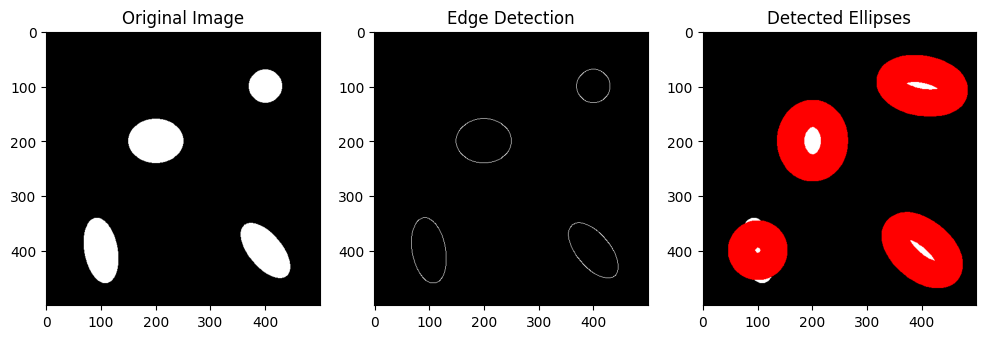

In [76]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

def compute_hough_ellipse_focus(edges, min_d=10, max_d=50, step_size=5):
    """
    Hough Transform for ellipse detection using the focus-based representation.
    
    Parameters:
    - edges: Binary edge image (numpy array)
    - min_d, max_d: Range of sum of distances defining the ellipse
    - step_size: Step size for reducing the search space

    Returns:
    - accumulator: Dictionary storing votes for (f1, f2, d)
    """
    edge_points = np.argwhere(edges > 0)
    accumulator = defaultdict(int)

    # Iterate over pairs of edge points as possible foci
    for (x1, y1), (x2, y2) in combinations(edge_points, 2):
        f1, f2 = (x1, y1), (x2, y2)
        d_min = max(min_d, np.linalg.norm(np.array(f1) - np.array(f2)))  # Minimum possible d
        d_values = np.arange(d_min, max_d, step_size)

        for d in d_values:
            accumulator[(x1, y1, x2, y2, int(d))] += 1  # Vote for (f1, f2, d)

    return accumulator


def extract_best_ellipses(accumulator, threshold_factor=0.5):
    """
    Extracts ellipses using non-maximum suppression.

    Parameters:
    - accumulator: Voting space from Hough transform
    - threshold_factor: Fraction of max votes to filter weak detections

    Returns:
    - List of (focus1, focus2, d) for detected ellipses
    """
    max_votes = max(accumulator.values()) if accumulator else 1
    threshold = threshold_factor * max_votes

    best_ellipses = [(x1, y1, x2, y2, d) for (x1, y1, x2, y2, d), votes in accumulator.items() if votes >= threshold]
    return best_ellipses


def adjust_foci_from_vertices(x1, y1, x2, y2, a, b):
    """
    Computes and adjusts the foci given the ellipse vertices.
    
    Parameters:
    - x1, y1: First vertex of the ellipse (one end of the major axis).
    - x2, y2: Second vertex of the ellipse (other end of the major axis).
    - a: Semi-major axis length.
    - b: Semi-minor axis length.

    Returns:
    - Adjusted foci positions (xf1, yf1, xf2, yf2).
    """
    # Compute focal distance `c`
    c = np.sqrt(a**2 - b**2) if a > b else 1  # Ensure valid computation

    # Compute unit direction vector along the major axis
    dx, dy = x2 - x1, y2 - y1
    norm = np.sqrt(dx**2 + dy**2) if dx**2 + dy**2 > 0 else 1
    ux, uy = dx / norm, dy / norm

    # Compute foci positions by moving inward along the major axis by distance `c`
    xf1, yf1 = x1 + c * ux, y1 + c * uy
    xf2, yf2 = x2 - c * ux, y2 - c * uy

    print(f'Adjusted Foci: ({xf1:.2f}, {yf1:.2f}), ({xf2:.2f}, {yf2:.2f})')
    return int(xf1), int(yf1), int(xf2), int(yf2)
  



def draw_ellipses(image, ellipses):
    """
    Draws detected ellipses on the image using two vertices.
    
    Parameters:
    - image: Input grayscale image
    - ellipses: List of detected ellipses [(x1, y1, x2, y2, d)]
    
    Returns:
    - Image with drawn ellipses.
    """
    # Ensure proper color format
    if len(image.shape) == 2:  # Grayscale image
        output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        output = image.copy()

    for (x1, y1, x2, y2, d) in ellipses:
        # Compute center
        xc, yc = (x1 + x2) // 2, (y1 + y2) // 2

        # Compute semi-major axis
        a = d / 2

        # Compute semi-minor axis using distance between vertices
        d_v = np.linalg.norm([x2 - x1, y2 - y1]) / 2
        b_squared = a**2 - d_v**2

        if b_squared < 0:
            continue  # Skip invalid ellipses

        b = np.sqrt(b_squared)

        # Compute ellipse orientation angle
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi

        # Draw ellipse (OpenCV expects center in (x, y) format)
        cv2.ellipse(output, (int(xc), int(yc)), (int(a), int(b)), angle, 0, 360, (255, 0, 0), 2)

    return output

# --- Test the implementation ---
# Load and preprocess an example image
image = cv2.imread(ellipse_path, cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(image, 100, 200)  # Edge detection

# Run Hough Transform
accumulator = compute_hough_ellipse_focus(edges)

# Extract best ellipses
best_ellipses = extract_best_ellipses(accumulator)

# Draw detected ellipses
output_img = draw_ellipses(image, best_ellipses)

# --- Visualization ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap="gray")
plt.title("Edge Detection")

plt.subplot(1, 3, 3)
plt.imshow(output_img)
plt.title("Detected Ellipses")

plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27032\4013977273.py:75: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(a**2 - (np.linalg.norm([x1 - x2, y1 - y2]) / 2) ** 2) if a > 0 else 1


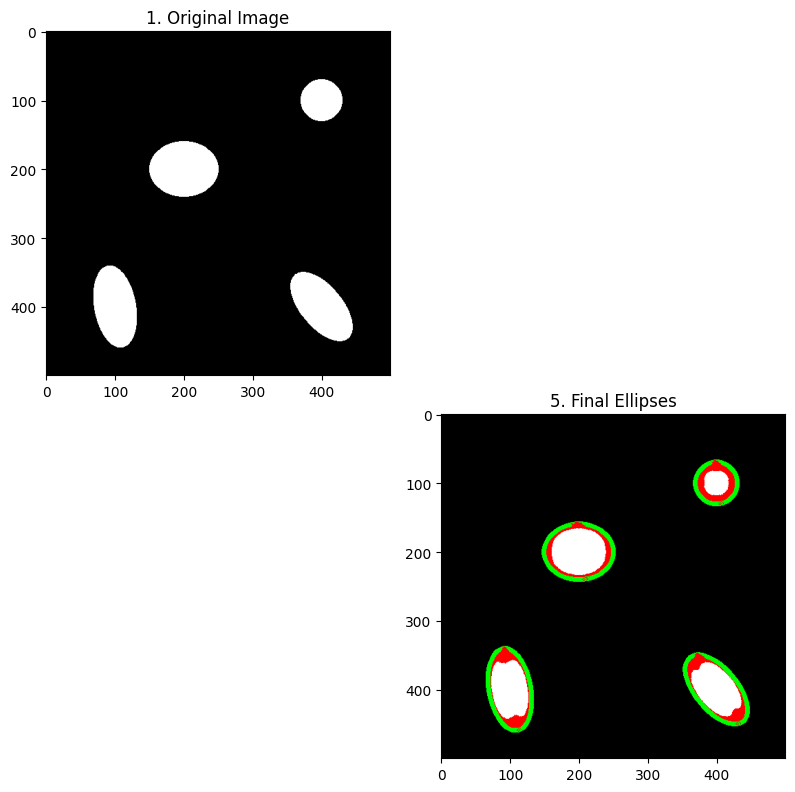

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations

def compute_hough_ellipse_focus(edges, min_d=10, max_d=50, step_size=x):
    """
    Hough Transform for ellipse detection using the focus-based representation.
    
    Parameters:
    - edges: Binary edge image (numpy array)
    - min_d, max_d: Range of sum of distances defining the ellipse
    - step_size: Step size for reducing the search space

    Returns:
    - accumulator: Dictionary storing votes for (f1, f2, d)
    - focus_pairs: List of focus point pairs considered
    """
    edge_points = np.argwhere(edges > 0)
    accumulator = defaultdict(int)
    focus_pairs = []

    # Iterate over pairs of edge points as possible foci
    for (x1, y1), (x2, y2) in combinations(edge_points, 2):
        f1, f2 = (x1, y1), (x2, y2)
        focus_pairs.append((f1, f2))

        d_min = max(min_d, np.linalg.norm(np.array(f1) - np.array(f2)))  # Minimum possible d
        d_values = np.arange(d_min, max_d, step_size)

        for d in d_values:
            accumulator[(x1, y1, x2, y2, int(d))] += 1  # Vote for (f1, f2, d)

    return accumulator, focus_pairs


def extract_best_ellipses(accumulator, threshold_factor=0.5):
    """
    Extracts ellipses using non-maximum suppression.

    Parameters:
    - accumulator: Voting space from Hough transform
    - threshold_factor: Fraction of max votes to filter weak detections

    Returns:
    - List of (focus1, focus2, d) for detected ellipses
    """
    max_votes = max(accumulator.values()) if accumulator else 1
    threshold = threshold_factor * max_votes

    best_ellipses = [(x1, y1, x2, y2, d) for (x1, y1, x2, y2, d), votes in accumulator.items() if votes >= threshold]
    return best_ellipses


def draw_ellipses(image, ellipses):
    """
    Draws detected ellipses on the input image.

    Parameters:
    - image: Original grayscale image
    - ellipses: List of detected ellipses with foci and distance sum
    """
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for (x1, y1, x2, y2, d) in ellipses:
        cv2.circle(output, (y1, x1), 3, (0, 255, 0), -1)  # Focus 1
        cv2.circle(output, (y2, x2), 3, (0, 255, 0), -1)  # Focus 2

        # Approximate ellipse center
        xc, yc = (x1 + x2) // 2, (y1 + y2) // 2

        # Compute major axis length (approximation)
        a = d / 2
        b = np.sqrt(a**2 - (np.linalg.norm([x1 - x2, y1 - y2]) / 2) ** 2) if a > 0 else 1
        a = a * 0.1
        b = b * 0.1
        if b > 0:
            angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            cv2.ellipse(output, (yc, xc), (int(a), int(b)), angle, 0, 360, (255, 0, 0), 1)

    return output


def plot_focus_pairs(image, focus_pairs):
    """
    Draws lines between focus point pairs.

    Parameters:
    - image: Original image
    - focus_pairs: List of focus point pairs considered
    """
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for (f1, f2) in focus_pairs:
        x1, y1 = f1
        x2, y2 = f2
        cv2.line(output, (y1, x1), (y2, x2), (0, 255, 255), 1)

    return output


def plot_accumulator_heatmap(accumulator):
    """
    Plots a heatmap of the votes in the Hough parameter space.

    Parameters:
    - accumulator: Dictionary storing votes for (f1, f2, d)
    """
    focus_x = []
    focus_y = []
    votes = []

    for (x1, y1, x2, y2, d), v in accumulator.items():
        focus_x.append(x1)
        focus_y.append(y1)
        votes.append(v)

    plt.figure(figsize=(6, 6))
    plt.scatter(focus_x, focus_y, c=votes, cmap='hot', alpha=0.6)
    plt.colorbar(label="Votes")
    plt.title("Hough Space Votes for Ellipse Detection")
    plt.xlabel("X (Focus 1)")
    plt.ylabel("Y (Focus 1)")
    plt.show()


# --- Test the implementation ---
# Load and preprocess an example image
image = cv2.imread(ellipse_path, cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(image, 100, 200)  # Edge detection

# Run Hough Transform
accumulator, focus_pairs = compute_hough_ellipse_focus(edges)

# Extract best ellipses
best_ellipses = extract_best_ellipses(accumulator)

# Visualize the focus point pairs
focus_pairs_img = plot_focus_pairs(image, focus_pairs)

# Draw detected ellipses
output_img = draw_ellipses(image, best_ellipses)

# --- Visualization ---
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("1. Original Image")



plt.subplot(2, 3, 5)
plt.imshow(output_img)
plt.title("5. Final Ellipses")

plt.tight_layout()
plt.show()
